# Plot results from LDA in ipynb 11 (without filtering columns)

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

%matplotlib inline
sns.set(style="white")

## LDA

In [2]:
from gensim import matutils, models, corpora

### Load saved model
num_topics = 10, passes = 20, trained on full feature set (no columns/hcpcs_codes dropped)

In [4]:
## Load lda model
model_fname = "11_lda_10_topics_noColsDropped.model"
ldamodel = models.LdaModel.load(model_fname)

## Load payments data, transform into corpus, get topics distribution per document

In [7]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [8]:
q = """SELECT npi, place_of_service, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments WHERE provider_type = 'Internal Medicine'"""
payments = pd.read_sql_query(q, con=con)

In [9]:
## only consider out of facility claims for now (see ipynb #13 for counts of each type)
by_npi = (payments.query('place_of_service == "O"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

In [10]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [30]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)

In [31]:
by_npi_topics.shape

(57331, 10)

## Load in fraud data for plotting

In [37]:
## excluded npis of provider_type internal medicine (excl date > 2015-01-01)
fraud_npi = pd.read_csv("internal_medicine_npi_fraud.csv", dtype={'npi':str})
fraud_idx = by_npi.index.isin(list(fraud_npi['npi']))

## Plot doctors in LDA topics space

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

In [33]:
X_centered = preprocessing.scale(by_npi_topics.as_matrix(), with_mean=True, with_std=False)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.22566592,  0.18795497,  0.1429627 ])

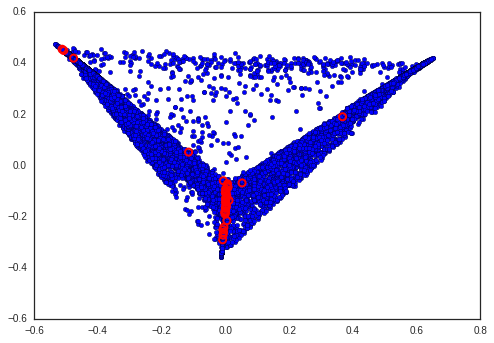

In [38]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

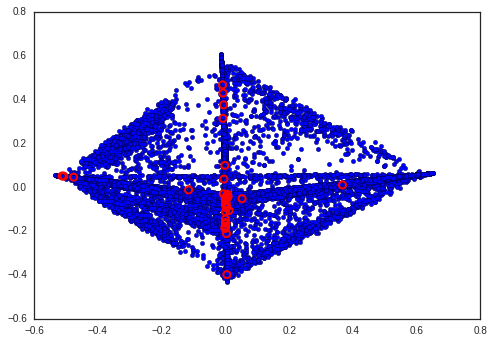

In [39]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

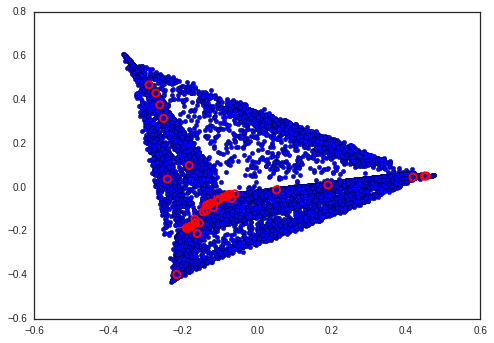

In [40]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,1], X_reduced[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

In [52]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
print(max_element_pc1)

## Topic 4  - blood testing

4


In [53]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
print(max_element_pc2)

## Topic 0 - vaccines

0


In [54]:
## locate the index of the largest absolute value in principle component 3
max_element_pc3 = np.argmax(np.absolute(svd.components_[2]))
print(max_element_pc3)

## Topic 1 - patient visit, routine (blood, urinalysis, vaccine)

1


## Plot points in original topics space
x = topic 6, y = topic 8

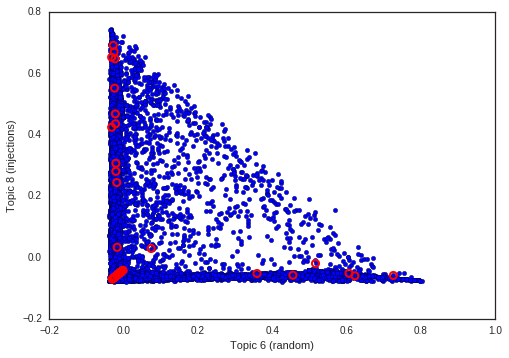

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X_centered[:,6], X_centered[:,8])
ax.scatter(X_centered[fraud_idx,6], X_centered[fraud_idx,8], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')
ax.set_xlabel("Topic 6 (random)")
ax.set_ylabel("Topic 8 (injections)")